In [1]:
!pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-76c18iqy
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-76c18iqy
  Resolved https://github.com/huggingface/transformers to commit bdee0889714e9cb3e53d3b1b2a626919479d356c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.0/516.0 kB 13.0 MB/s eta 0:00:0000:01
  Created wheel for transformers: filename=transformers-5.0.0.dev0-py3-none-any.whl size=11085249 sha256=f2cfc9d3794552ed1e98943028e36ba83bfc56b963e049d06daae7cc74cae0ec
  Stored in directory: /tmp/pip-ephem-wheel-cache-usgscojz/wheels/49/a7/50/c9fdabbf10e51bb1256adb0c1a587fedd7184f5bad28d47fe3
Successfully built transformers
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.36.0
    Uninstalling huggingface-hub-0.36

In [2]:
from huggingface_hub import login
login()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


In [3]:
!wget -O image.png "https://markomilenkovic.rs/random_media/lauzhack_svasta.png"

--2025-11-23 08:22:01--  https://markomilenkovic.rs/random_media/lauzhack_svasta.png
Resolving markomilenkovic.rs (markomilenkovic.rs)... 185.199.109.153, 185.199.110.153, 185.199.111.153, ...
Connecting to markomilenkovic.rs (markomilenkovic.rs)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1504557 (1.4M) [image/png]
Saving to: ‘image.png’

image.png           100%[===================>]   1.43M  --.-KB/s    in 0.03s   

2025-11-23 08:22:01 (46.6 MB/s) - ‘image.png’ saved [1504557/1504557]



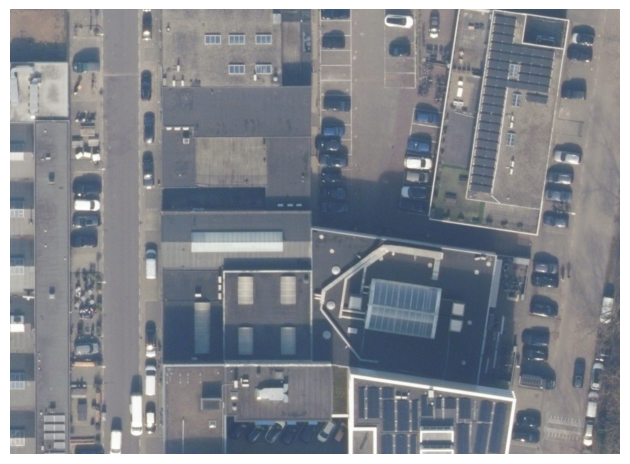

In [4]:
from pathlib import Path
from IPython.display import display
from PIL import Image


import matplotlib.pyplot as plt

p = "image.png"
image = Image.open("image.png")

plt.imshow(image)
plt.axis("off")
plt.tight_layout()
plt.show()

In [5]:
from transformers import Sam3Processor, Sam3Model
from PIL import Image, ImageDraw
import torch
import numpy as np
import matplotlib
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull

def compute_orientation(mask, threshold=0.5):
    """
    Estimate orientation using PCA on mask pixels.
    Returns (angle_deg, centroid_xy, major_len, minor_len) or None if empty.
    angle_deg: degrees from image +x axis (right) positive CCW.
    centroid_xy: (x, y) in image coordinates.
    """
    if torch.is_tensor(mask):
        arr = mask.cpu().numpy()
    else:
        arr = np.array(mask)

    # normalize to boolean
    if arr.dtype == np.uint8 or arr.max() > 1:
        bw = arr > 127
    else:
        bw = arr > threshold

    coords = np.column_stack(np.where(bw))  # rows (y), cols (x)
    if coords.size == 0:
        return None

    centroid = coords.mean(axis=0)  # (y, x)
    centered = coords - centroid
    if centered.shape[0] < 2:
        return None

    cov = np.cov(centered, rowvar=False)  # 2x2 cov of [y, x]
    eigvals, eigvecs = np.linalg.eigh(cov)
    # largest eigenvalue -> principal axis
    idx = np.argmax(eigvals)
    major_vec = eigvecs[:, idx]  # [vy, vx]
    # convert to (vx, vy) and normalize
    vx, vy = float(major_vec[1]), float(major_vec[0])
    norm = np.hypot(vx, vy) or 1.0
    vx /= norm; vy /= norm

    angle_rad = np.arctan2(vy, vx)
    angle_deg = np.degrees(angle_rad)

    # approximate axis lengths from eigenvalues (scale factor arbitrary)
    major_len = 2.0 * np.sqrt(max(eigvals[idx], 0.0))
    minor_len = 2.0 * np.sqrt(max(eigvals[1-idx], 0.0))

    # centroid in (x, y)
    centroid_xy = (float(centroid[1]), float(centroid[0]))
    return angle_deg, centroid_xy, major_len, minor_len

def overlay_masks(image, masks, draw_orientations=True):
    image = image.convert("RGBA")
    masks_np = 255 * masks.cpu().numpy().astype(np.uint8)
    
    n_masks = masks_np.shape[0]
    cmap = matplotlib.colormaps.get_cmap("rainbow").resampled(n_masks)
    colors = [
        tuple(int(c * 255) for c in cmap(i)[:3])
        for i in range(n_masks)
    ]

    orientations = []
    for mask, color in zip(masks_np, colors):
        mask_img = Image.fromarray(mask)
        overlay = Image.new("RGBA", image.size, color + (0,))
        alpha = mask_img.point(lambda v: int(v * 0.5))
        overlay.putalpha(alpha)
        image = Image.alpha_composite(image, overlay)

        # compute orientation for this mask
        orient = compute_orientation(mask)
        orientations.append((orient, color))

    if draw_orientations:
        draw = ImageDraw.Draw(image)
        for item in orientations:
            orient, color = item
            if orient is None:
                continue
            angle_deg, (cx, cy), major_len, minor_len = orient
            # draw a line for the major axis (scaled for visibility)
            L = max(20, major_len * 4)
            # direction vector
            ang = np.radians(angle_deg)
            dx = np.cos(ang) * L
            dy = np.sin(ang) * L
            # image coordinates: x right, y down (PIL uses same)
            start = (cx - dx, cy - dy)
            end = (cx + dx, cy + dy)
            draw.line([start, end], fill=(255,255,255,255), width=3)
            # small circle at centroid
            r = 4
            draw.ellipse([cx-r, cy-r, cx+r, cy+r], fill=(255,255,255,255))

    return image, orientations

def minimal_axis_angle_diff(a_deg, b_deg):
    """
    Return smallest absolute angle difference between two axial angles (degrees).
    Accounts for 180-degree axis ambiguity and returns value in [0, 90].
    """
    # minimal difference on circle
    raw = abs(((a_deg - b_deg + 180) % 360) - 180)  # in [0,180]
    if raw > 90:
        raw = 180 - raw
    return raw



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Sam3Model.from_pretrained("facebook/sam3").to(device)
processor = Sam3Processor.from_pretrained("facebook/sam3")

config.json:   0%|          | 0.00/25.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/1468 [00:00<?, ?it/s]

processor_config.json:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.64M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]


Detecting cars and estimating their orientations...
Initially found 57 car objects. Filtering by aspect ratio and area...
Found 46 car objects after filtering


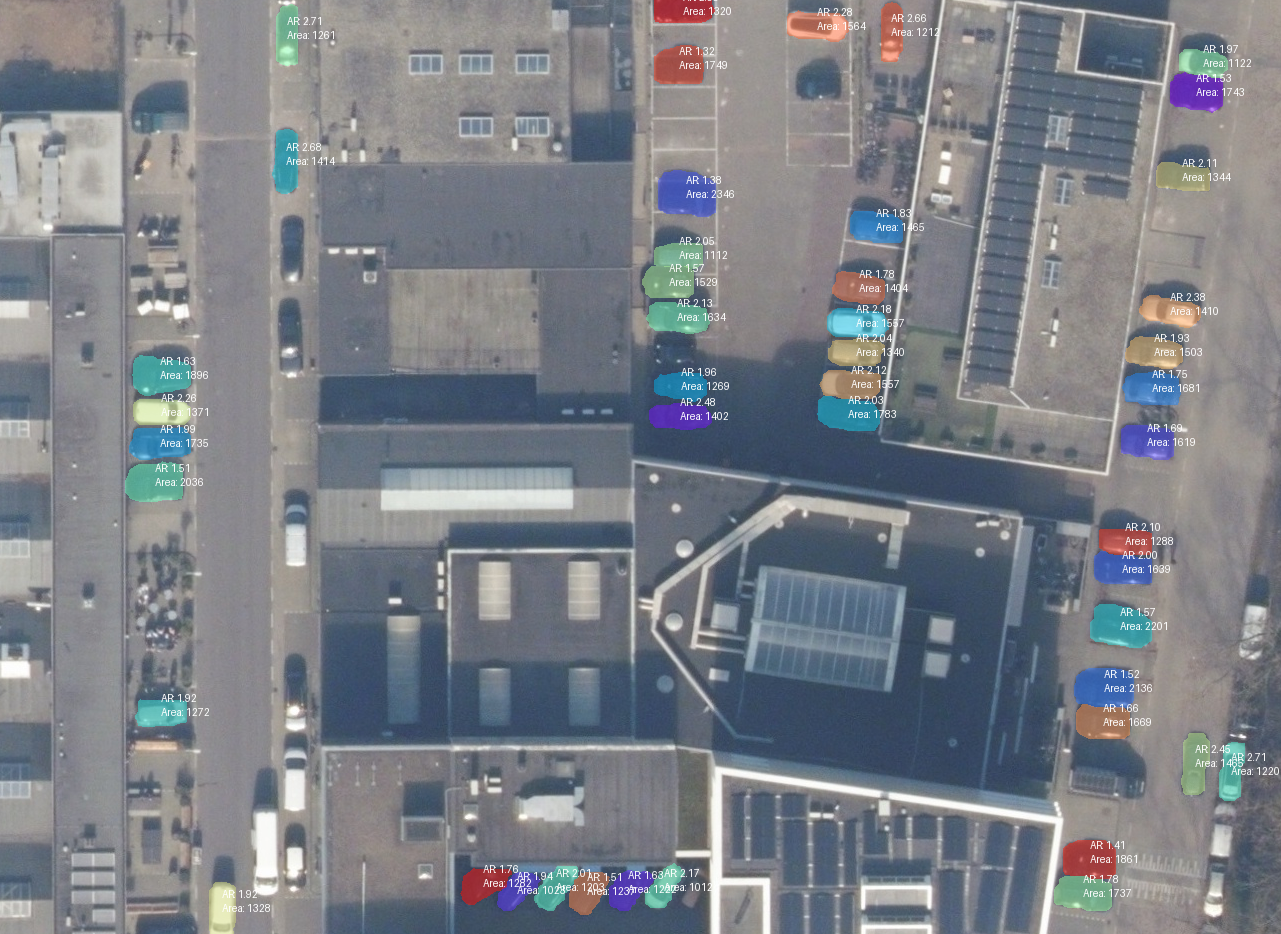

In [6]:
# detect cars and estimate orientations
from IPython.display import display
print("\nDetecting cars and estimating their orientations...")

inputs_cars = processor(images=image, text="car body", return_tensors="pt").to(device)

with torch.no_grad():
    outputs_cars = model(**inputs_cars)

results_cars = processor.post_process_instance_segmentation(
    outputs_cars,
    threshold=0.5,
    mask_threshold=0.5,
    target_sizes=inputs_cars.get("original_sizes").tolist()
)[0]

print(f"Initially found {len(results_cars['masks'])} car objects. Filtering by aspect ratio and area...")

# --- Filter by aspect ratio and area ---
keep_indices = []
min_aspect_ratio = 1.3
max_aspect_ratio = 2.8
min_area = 800  # Minimum area in pixels to be considered a car
max_area = 2500 # Maximum area in pixels to exclude trucks

for i, mask in enumerate(results_cars["masks"]):
    # Calculate area
    if torch.is_tensor(mask):
        mask_np = mask.cpu().numpy()
    else:
        mask_np = np.array(mask)
    
    # Check if mask is boolean or 0-1 or 0-255
    if mask_np.dtype == bool:
        area = np.sum(mask_np)
    else:
        area = np.sum(mask_np > 0)
        
    if area < min_area or area > max_area:
        continue

    orient = compute_orientation(mask)
    if orient is None:
        continue
    _, _, major_len, minor_len = orient
    if minor_len < 1.0: # Avoid division by zero
        continue
    
    aspect_ratio = major_len / minor_len
    if min_aspect_ratio <= aspect_ratio <= max_aspect_ratio:
        keep_indices.append(i)

# Apply filter
results_cars["masks"] = results_cars["masks"][keep_indices]
results_cars["scores"] = results_cars["scores"][keep_indices]
if "labels" in results_cars:
    results_cars["labels"] = results_cars["labels"][keep_indices]

print(f"Found {len(results_cars['masks'])} car objects after filtering")

cars_image, car_orientations = overlay_masks(image, results_cars["masks"], draw_orientations=False)
draw = ImageDraw.Draw(cars_image)

for i, (orient, _) in enumerate(car_orientations):
    if orient is None:
        pass
        # print(f"Car {i}: no mask pixels")
    else:
        # Calculate area for display
        mask = results_cars["masks"][i]
        if torch.is_tensor(mask):
            mask_np = mask.cpu().numpy()
        else:
            mask_np = np.array(mask)
        
        if mask_np.dtype == bool:
            area = np.sum(mask_np)
        else:
            area = np.sum(mask_np > 0)

        angle_deg, centroid_xy, major_len, minor_len = orient
        # print(f"Car {i}: angle={angle_deg:.1f}°, centroid={centroid_xy}, major={major_len:.1f}, minor={minor_len:.1f}")
        
        if minor_len > 0:
            ar = major_len / minor_len
            # Draw aspect ratio and area above the centroid
            text = f"AR: {ar:.2f}\nArea: {area}"
            draw.text((centroid_xy[0], centroid_xy[1] - 20), text, fill="white")

display(cars_image)

In [7]:
# --- roads detection (kept for visualization & filtering) --- #
print("\nDetecting roads...")

# prepare inputs for 'roads'
inputs_roads = processor(images=image, text="street road", return_tensors="pt").to(device)

with torch.no_grad():
    outputs_roads = model(**inputs_roads)

results_roads = processor.post_process_instance_segmentation(
    outputs_roads,
    threshold=0.4,
    mask_threshold=0.55,
    target_sizes=inputs_roads.get("original_sizes").tolist()
)[0]

print(f"Found {len(results_roads['masks'])} road objects")

# road masks as numpy (H, W) bool
road_masks = results_roads["masks"]
if torch.is_tensor(road_masks):
    road_masks_np = road_masks.cpu().numpy().astype(bool)
else:
    road_masks_np = np.array(road_masks).astype(bool)

# Just overlay road masks (no angle logic)
road_image, road_orientations = overlay_masks(image, results_roads["masks"], draw_orientations=False)

### --- REMOVE CARS THAT ARE ON ROADS (DISTANCE-BASED) --- ###
print("\n=== Filtering out cars that are on roads (distance-based) ===")

car_masks = results_cars["masks"]
on_road_flags = []

# Precompute union road mask and distance transform for "off-road" detection
if road_masks_np.size == 0:
    union_road = None
    dist_map = None
    print("No road masks available, skipping road-based filtering.")
else:
    from scipy.ndimage import distance_transform_edt

    union_road = road_masks_np.any(axis=0)  # (H, W) bool

    # Distance map: for each non-road pixel, distance to nearest road pixel.
    # distance = 0 inside road; grows as you move away.
    dist_map = distance_transform_edt(~union_road)

# Threshold in pixels: if car centroid is within this distance of a road, treat as on-road
road_dist_thresh = 40.0  # tweak as needed

for i, mask in enumerate(car_masks):
    if torch.is_tensor(mask):
        car_mask_np = mask.cpu().numpy()
    else:
        car_mask_np = np.array(mask)

    # binarize car mask
    if car_mask_np.dtype == bool:
        car_bin = car_mask_np
    else:
        car_bin = car_mask_np > 0

    car_area = car_bin.sum()
    if car_area == 0 or dist_map is None:
        # if no area or no roads, treat as off-road
        on_road_flags.append(False)
        continue

    # centroid from mask
    ys, xs = np.where(car_bin)
    cy = int(round(ys.mean()))
    cx = int(round(xs.mean()))

    # clamp to image bounds
    h, w = dist_map.shape
    cy = max(0, min(h - 1, cy))
    cx = max(0, min(w - 1, cx))

    dist_to_road = dist_map[cy, cx]

    # consider "on road" if centroid lies close to a road
    on_road = dist_to_road <= road_dist_thresh
    on_road_flags.append(on_road)

n_on_road = sum(on_road_flags)
print(f"Cars near roads (filtered out): {n_on_road}")
print(f"Cars off roads (kept for clustering): {len(on_road_flags) - n_on_road}")

### --- CLUSTER OFF-ROAD CARS INTO GROUPS AND VISUALIZE --- ###
print("\n=== Clustering OFF-ROAD cars into groups ===")

if len(car_orientations) == 0:
    print("No cars detected - cannot cluster.")
    clustered_image = cars_image.copy()
else:
    # collect centroids for off-road cars only
    offroad_centroids = []
    offroad_indices = []  # indices into car_orientations / results_cars

    for i, (orient, _) in enumerate(car_orientations):
        if on_road_flags[i]:
            continue  # skip cars that are on roads

        if orient is not None:
            _, centroid, _, _ = orient
            offroad_centroids.append(centroid)
            offroad_indices.append(i)
        else:
            # approximate centroid from mask if orientation is missing
            mask = results_cars["masks"][i]
            if torch.is_tensor(mask):
                mask_np = mask.cpu().numpy()
            else:
                mask_np = np.array(mask)
            ys, xs = np.where(mask_np > 0)
            if len(xs) == 0:
                continue
            offroad_centroids.append((float(xs.mean()), float(ys.mean())))
            offroad_indices.append(i)

    if len(offroad_centroids) == 0:
        print("No off-road cars to cluster.")
        clustered_image = cars_image.copy()
    else:
        offroad_centroids = np.array(offroad_centroids)

        # DBSCAN with permissive settings: every off-road car belongs to some cluster
        eps = 150  # pixels
        min_samples = 1  # this forces every point to belong to a cluster
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(offroad_centroids)
        labels = clustering.labels_

        unique_labels = sorted(set(labels))
        print(f"Total off-road cars: {len(offroad_centroids)}")
        print(f"Number of clusters (including singletons): {len(unique_labels)}")

        # create visualization image (start from original image)
        clustered_image = image.copy().convert("RGBA")
        draw = ImageDraw.Draw(clustered_image)

        # create visualization image (start from original image)
        clustered_image = image.copy().convert("RGBA")

        # also lightly show roads in the background
        roads_vis, _ = overlay_masks(image.copy(),  # use original image
                                    results_roads["masks"],
                                    draw_orientations=False)
        clustered_image = roads_vis.convert("RGBA")  # Convert back to RGBA!
        draw = ImageDraw.Draw(clustered_image)

        # color palette for clusters
        base_colors = [
            (255, 0, 0),
            (0, 255, 0),
            (0, 0, 255),
            (255, 255, 0),
            (255, 0, 255),
            (0, 255, 255),
            (255, 128, 0),
            (128, 0, 255),
            (0, 128, 255),
            (128, 255, 0),
        ]

        from scipy.spatial import ConvexHull

        # Create a transparent overlay layer
        overlay = Image.new('RGBA', clustered_image.size, (0, 0, 0, 0))
        overlay_draw = ImageDraw.Draw(overlay)

        for lbl in unique_labels:
            # all off-road cars in this cluster
            idxs = np.where(labels == lbl)[0]
            if len(idxs) == 0:
                continue
            color = base_colors[lbl % len(base_colors)] if lbl != -1 else (200, 200, 200)

            # get centroids for this cluster
            cluster_points = offroad_centroids[idxs]
            
            # draw convex hull around cluster
            if len(cluster_points) >= 3:
                hull = ConvexHull(cluster_points)
                hull_points = cluster_points[hull.vertices]
                polygon = [tuple(point) for point in hull_points]
                overlay_draw.polygon(polygon, fill=color + (50,), outline=color + (255,), width=3)  # 50 = transparency
            elif len(cluster_points) == 2:
                p1, p2 = cluster_points
                padding = 20
                overlay_draw.line([tuple(p1), tuple(p2)], fill=color + (255,), width=3)
                for p in cluster_points:
                    overlay_draw.ellipse([p[0]-padding, p[1]-padding, p[0]+padding, p[1]+padding],
                                outline=color + (255,), width=3)
            else:
                p = cluster_points[0]
                padding = 30
                overlay_draw.ellipse([p[0]-padding, p[1]-padding, p[0]+padding, p[1]+padding],
                            fill=color + (50,), outline=color + (255,), width=3)  # 50 = transparency

        # Composite the overlay onto the base image
        clustered_image = Image.alpha_composite(clustered_image, overlay)
        draw = ImageDraw.Draw(clustered_image)

        # Now draw the cluster labels on top
        for lbl in unique_labels:
            idxs = np.where(labels == lbl)[0]
            if len(idxs) == 0:
                continue
            cluster_center = offroad_centroids[idxs].mean(axis=0)
            label_text = f"C{lbl if lbl >= 0 else 'N'} ({len(idxs)})"
            draw.text((cluster_center[0], cluster_center[1]),
                    label_text,
                    fill=(255, 255, 255, 255))

print("Clustering and visualization complete.")


Detecting roads...
Found 3 road objects

=== Filtering out cars that are on roads (distance-based) ===
Cars near roads (filtered out): 23
Cars off roads (kept for clustering): 23

=== Clustering OFF-ROAD cars into groups ===
Total off-road cars: 23
Number of clusters (including singletons): 4
Clustering and visualization complete.


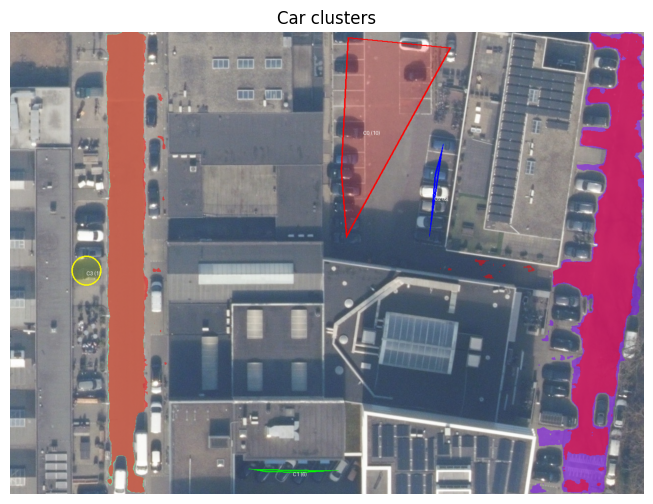

In [8]:
plt.figure(figsize=(12, 6))
plt.imshow(clustered_image)
plt.axis("off")
plt.title("Car clusters")
plt.show()

In [11]:
import numpy as np
from PIL import Image, ImageDraw
import torch
from scipy.spatial import ConvexHull
from matplotlib.path import Path

def get_obb_corners(center, width, height, angle_deg):
    """
    Calculate the 4 corners of an OBB.
    width: full width (along minor axis)
    height: full length (along major axis)
    """
    cx, cy = center
    theta = np.radians(angle_deg)
    
    # Vectors for half-width (dx) and half-height (dy)
    # Major axis is along 'angle', Minor is perpendicular
    
    # Major axis vector (half length)
    ux = np.cos(theta) * (height / 2)
    uy = np.sin(theta) * (height / 2)
    
    # Minor axis vector (half width) - perpendicular (-sin, cos)
    vx = -np.sin(theta) * (width / 2)
    vy = np.cos(theta) * (width / 2)
    
    # Corners: center +/- major +/- minor
    c1 = (cx + ux + vx, cy + uy + vy)
    c2 = (cx + ux - vx, cy + uy - vy)
    c3 = (cx - ux - vx, cy - uy - vy)
    c4 = (cx - ux + vx, cy - uy + vy)
    
    return [c1, c2, c3, c4]

def infer_parking_spaces(image, car_masks, car_orientations, offroad_indices, clustering_labels, road_mask_np=None, debug=False):
    """
    Infer parking spaces by checking around detected cars recursively.
    Constrained by the convex hull of the cluster.
    Filters out cars with orientation > 60 degrees from cluster mean.
    """
    h, w = image.size[1], image.size[0]
    
    def get_angle_diff(a, b):
        diff = abs(((a - b + 180) % 360) - 180)
        if diff > 90: diff = 180 - diff
        return diff

    # 1. Group cars by cluster
    clusters = {}
    for idx, label in zip(offroad_indices, clustering_labels):
        if label == -1: continue # Noise
        if label not in clusters: clusters[label] = []
        clusters[label].append(idx)
        
    parking_spots = [] # List of dicts: {'type': 'occupied'|'empty', 'corners': [...]}
    debug_candidates = []
    cluster_hulls = [] # Store polygons for visualization
    
    # Create a mask of all off-road cars for fast overlap checking
    all_cars_mask = np.zeros((h, w), dtype=np.uint8)
    for idx in offroad_indices:
        mask = car_masks[idx]
        if torch.is_tensor(mask): mask = mask.cpu().numpy()
        all_cars_mask = np.maximum(all_cars_mask, mask.astype(np.uint8))
        
    # Mask to keep track of inferred spots to prevent overlap
    inferred_spots_mask = np.zeros((h, w), dtype=np.uint8)

    # 2. Process each cluster
    for label, indices in clusters.items():
        # First pass: collect all potential cars
        raw_cars = []
        angles = []
        
        for idx in indices:
            orient = car_orientations[idx][0] # (angle, center, major, minor)
            if orient is None: continue
            
            angle, center, major, minor = orient
            # PCA major/minor are approx half-lengths. 
            # Let's use a heuristic multiplier based on visual fit.
            l = major * 1.8
            wd = minor * 1.8
            
            raw_cars.append({'center': center, 'angle': angle, 'l': l, 'w': wd, 'idx': idx})
            angles.append(angle)
            
        if not raw_cars: continue
        
        # Calculate circular mean orientation for the cluster
        # Double angles to handle 180-degree ambiguity (axial data)
        angles_rad = np.radians(np.array(angles)) * 2
        mean_sin = np.mean(np.sin(angles_rad))
        mean_cos = np.mean(np.cos(angles_rad))
        mean_angle = np.degrees(np.arctan2(mean_sin, mean_cos) / 2)
        
        # Filter cars based on orientation
        cluster_cars = []
        cluster_points = []
        widths = []
        lengths = []
        all_cluster_corners = []
        
        for car in raw_cars:
            diff = get_angle_diff(car['angle'], mean_angle)
            if diff > 60:
                continue # Skip outlier
            
            cluster_cars.append(car)
            cluster_points.append(car['center'])
            widths.append(car['w'])
            lengths.append(car['l'])
            
            # Collect corners for hull (Lasso effect)
            corners = get_obb_corners(car['center'], car['w'], car['l'], car['angle'])
            all_cluster_corners.extend(corners)

        # Skip singleton clusters (after filtering)
        if len(cluster_cars) <= 2:
            continue
        
        avg_len = np.median(lengths)
        avg_width = np.median(widths)
        
        # Define search stride (width + small gap)
        step_dist = avg_width * 1.05 
        
        # Detect Row Axis (Minimum Area Rectangle) & Build Boundary
        cluster_path = None
        row_vector = None
        row_point = None
        
        if len(all_cluster_corners) >= 3:
            points = np.array(all_cluster_corners)
            try:
                hull = ConvexHull(points)
                hull_points = points[hull.vertices]
                
                # Use the Convex Hull of corners as the boundary (Lasso)
                cluster_path = Path(hull_points)
                cluster_hulls.append([tuple(p) for p in hull_points])
                
                min_area = float('inf')
                best_rect_params = None
                
                # Check each edge of the hull for MAR (Row Axis detection)
                num_v = len(hull_points)
                for i in range(num_v):
                    p1 = hull_points[i]
                    p2 = hull_points[(i + 1) % num_v]
                    
                    edge = p2 - p1
                    norm = np.linalg.norm(edge)
                    if norm < 1e-6: continue
                    
                    # Normalized edge vector (axis 1)
                    u = edge / norm
                    # Perpendicular vector (axis 2)
                    v = np.array([-u[1], u[0]])
                    
                    # Project all points onto axes
                    proj_u = np.dot(hull_points, u)
                    proj_v = np.dot(hull_points, v)
                    
                    min_u, max_u = np.min(proj_u), np.max(proj_u)
                    min_v, max_v = np.min(proj_v), np.max(proj_v)
                    
                    w_rect = max_u - min_u
                    h_rect = max_v - min_v
                    area = w_rect * h_rect
                    
                    if area < min_area:
                        min_area = area
                        best_rect_params = (u, v, min_u, max_u, min_v, max_v, w_rect, h_rect)
                
                if best_rect_params:
                    u, v, min_u, max_u, min_v, max_v, w_rect, h_rect = best_rect_params
                    
                    # Select the longer axis as the row vector
                    if w_rect > h_rect:
                        r_vec = u
                    else:
                        r_vec = v
                    
                    # Center of the rectangle
                    center_u = (min_u + max_u) / 2
                    center_v = (min_v + max_v) / 2
                    r_center = center_u * u + center_v * v
                    
                    car_rad = np.radians(mean_angle)
                    car_vec = np.array([np.cos(car_rad), np.sin(car_rad)])
                    dot = np.abs(np.dot(r_vec, car_vec))
                    
                    if dot < 0.8: # Side-by-side / Diagonal
                        row_vector = r_vec
                        row_point = r_center
                        sin_alpha = np.sqrt(1 - dot**2)
                        if sin_alpha > 0.1:
                            step_dist = (avg_width * 1.05) / sin_alpha
                            if step_dist > avg_len * 1.5: step_dist = avg_width * 1.05
            except Exception:
                pass 
        
        # Queue for BFS: (center, angle, width, length)
        queue = []
        visited_centers = [] # Keep track to avoid infinite loops locally
        
        # Initialize queue with existing cars
        for car in cluster_cars:
            queue.append(car)
            visited_centers.append(car['center'])
            
            # Add occupied spot (using average dimensions for uniformity)
            car_corners = get_obb_corners(car['center'], avg_width, avg_len, car['angle'])
            parking_spots.append({'type': 'occupied', 'corners': car_corners})

        # 3. Recursive Search (BFS)
        while queue:
            current_item = queue.pop(0)
            curr_center = current_item['center']
            curr_angle = current_item['angle']
            
            candidates = []
            if row_vector is not None:
                for sign in [1, -1]:
                    # Step along the row vector from the current center
                    step = row_vector * step_dist * sign
                    cand_center = np.array(curr_center) + step
                    candidates.append(tuple(cand_center))
            else:
                perp_angle = curr_angle + 90
                for direction in [1, -1]:
                    rad = np.radians(perp_angle)
                    dx = np.cos(rad) * step_dist * direction
                    dy = np.sin(rad) * step_dist * direction
                    candidates.append((curr_center[0] + dx, curr_center[1] + dy))

            for cand_center in candidates:
                
                if debug:
                    d_corners = get_obb_corners(cand_center, avg_width, avg_len, curr_angle)
                    debug_candidates.append(d_corners)

                # Check bounds
                cx, cy = cand_center
                if cx < 0 or cx >= w or cy < 0 or cy >= h: continue
                
                # CONSTRAINT: Check if inside Convex Hull
                if cluster_path:
                    if not cluster_path.contains_point(cand_center):
                        continue
                
                # Get candidate OBB corners
                cand_corners = get_obb_corners(cand_center, avg_width, avg_len, curr_angle)
                
                # Rasterize candidate for IoU check using PIL
                mask_img = Image.new('L', (w, h), 0)
                ImageDraw.Draw(mask_img).polygon(cand_corners, outline=1, fill=1)
                cand_mask = np.array(mask_img)
                
                cand_area = np.sum(cand_mask)
                if cand_area == 0: continue
                
                # Check overlap with existing cars
                overlap = np.sum(cand_mask & all_cars_mask)
                overlap_ratio = overlap / cand_area
                
                if overlap_ratio > 0.25:
                    # This spot is occupied by a car
                    # We don't add to queue because existing cars are already in queue
                    pass 
                else:
                    # Potential empty spot
                    # Check road overlap
                    if road_mask_np is not None:
                        # road_mask_np might be boolean
                        road_overlap = np.sum(cand_mask & road_mask_np.astype(np.uint8))
                        if (road_overlap / cand_area) > 0.2:
                            continue # On the road
                    
                    # Check overlap with already inferred spots (deduplication)
                    overlap_inferred = np.sum(cand_mask & inferred_spots_mask)
                    if (overlap_inferred / cand_area) > 0.25:
                        continue # Overlaps too much with another empty spot
                    
                    # Found a valid empty spot!
                    new_spot = {'type': 'empty', 'corners': cand_corners, 'center': cand_center, 'angle': curr_angle}
                    parking_spots.append(new_spot)
                    inferred_spots_mask = np.maximum(inferred_spots_mask, cand_mask)
                    
                    # Add to queue to continue search recursively
                    queue.append(new_spot)

    # 4. Visualization
    vis_image = image.copy().convert("RGBA")
    draw = ImageDraw.Draw(vis_image)

    if debug:
        for poly in debug_candidates:
            draw.polygon([tuple(p) for p in poly], outline=(0, 0, 255, 150), width=2)

        # Draw convex hulls for each cluster
        for poly in cluster_hulls:
            draw.polygon(poly, fill=(0, 255, 255, 30), outline=(0, 255, 255, 150))

    # Draw empty and occupied spots
    for spot in parking_spots:
        poly = [tuple(p) for p in spot['corners']]
        if spot['type'] == 'empty':
            # Draw green polygon
            draw.polygon(poly, fill=(0, 255, 0, 100), outline=(0, 255, 0, 255))
        elif spot['type'] == 'occupied':
            # Draw red polygon
            draw.polygon(poly, fill=(255, 0, 0, 100), outline=(255, 0, 0, 255))
            
    return vis_image, parking_spots

Inferring parking spaces...
Inferred 31 parking spots.
Inferred 31 parking spots.


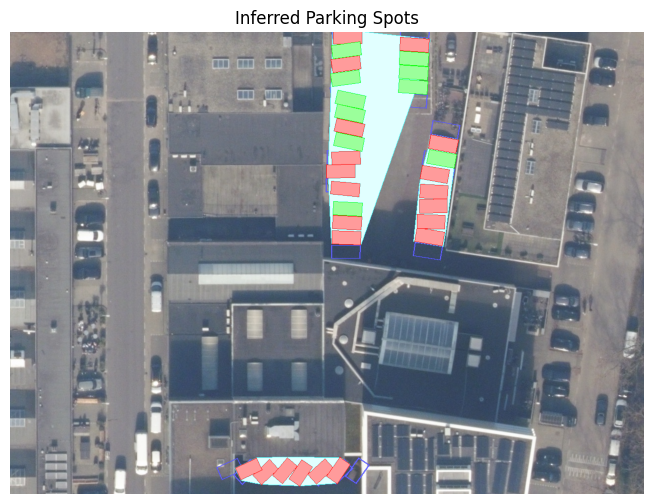

In [13]:
print("Inferring parking spaces...")

# Combine road masks into a single mask if available
if len(results_roads["masks"]) > 0:
    if torch.is_tensor(results_roads["masks"]):
        road_mask_combined = results_roads["masks"].any(dim=0).cpu().numpy()
    else:
        road_mask_combined = np.array(results_roads["masks"]).any(axis=0)
else:
    road_mask_combined = None

inferred_image, spots = infer_parking_spaces(
    image, 
    results_cars["masks"], 
    car_orientations, 
    offroad_indices, 
    labels, 
    road_mask_np=road_mask_combined,
    debug=True
)

print(f"Inferred {len(spots)} parking spots.")

plt.figure(figsize=(12, 6))
plt.imshow(inferred_image)
plt.axis("off")
plt.title("Inferred Parking Spots")
plt.show()